loading images...
loading labels for train target
scaling raw pixel intensities
splitting data
compiling model...
fitting model...
Epoch 1/50
332/332 [==============================] - 132s 397ms/step - loss: 0.5489 - acc: 0.7381 - val_loss: 0.5043 - val_acc: 0.7798
Epoch 2/50
332/332 [==============================] - 117s 353ms/step - loss: 0.5111 - acc: 0.7626 - val_loss: 0.4615 - val_acc: 0.7958
Epoch 3/50
332/332 [==============================] - 118s 355ms/step - loss: 0.4798 - acc: 0.7831 - val_loss: 0.4304 - val_acc: 0.8165
Epoch 4/50
332/332 [==============================] - 121s 363ms/step - loss: 0.4676 - acc: 0.7916 - val_loss: 0.4204 - val_acc: 0.8209
Epoch 5/50
332/332 [==============================] - 123s 370ms/step - loss: 0.4534 - acc: 0.8027 - val_loss: 0.4152 - val_acc: 0.8220
Epoch 6/50
332/332 [==============================] - 120s 360ms/step - loss: 0.4309 - acc: 0.8126 - val_loss: 0.3749 - val_acc: 0.8426
Epoch 7/50
332/332 [==============================] -

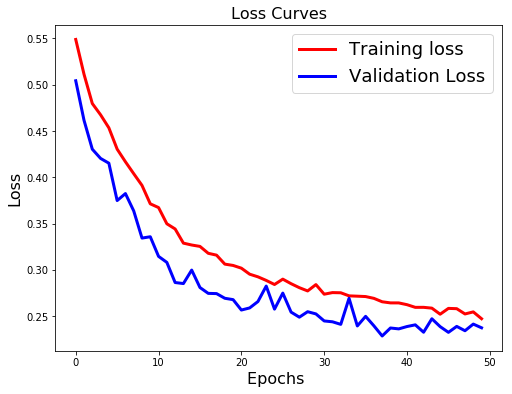

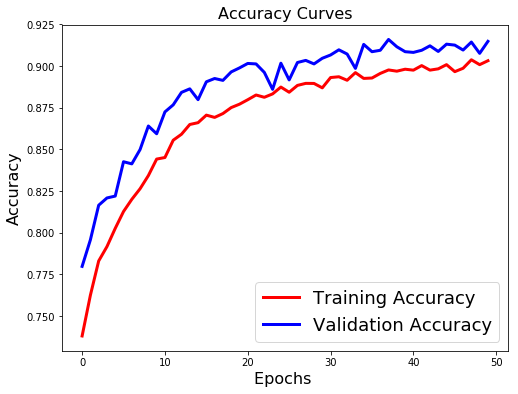

In [3]:
############################################ STEP 1:IMPORTING PACKAGES ############################################################
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from keras import backend as K
 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os
import pandas as pd
from keras.models import load_model
from keras.utils import np_utils
import re 

############################################### STEP 2:FUNCTIONS #############################################################
def sortList(l): 
    #sorting file names alphanumerically(train_1.jpg,train_2.jpg,train_3.jpg..)
    #by default, python sort files in order like train_1.jpg,train_11.jpg,train_112.jpg...
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

#building model
def build():
    # Initialising the CNN using keras inbuilt model function 'Sequential'
    classifier = Sequential()
    # 1: Convolution and Pooling layer withh filter numbers: 32 and kernel size=3,3
    # image size as 48 by 48 and relu as activation function
    classifier.add(Conv2D(32, (3, 3), input_shape = (48, 48, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # 2: second convolutional and pooling layer
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # 3: Adding convolutional and pooling layer
    classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # 4: Flattening to convert the output to 1D feature vector for input to dense layer
    classifier.add(Flatten())
    # 5: Using Full connection
    classifier.add(Dense(units = 512, activation = 'relu'))
    classifier.add(Dropout(0.5))
    #using sigmoid function to get probability in range (0,1)
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    
    return classifier

########################################## STEP 3: INITIALIZATION ###########################################################
# initializing the number of epochs to train the model for, initial learning rate and batch size
EPOCHS =50
learingRate=1e-3
batchSize=64
 
# initialize the data and labels and loading data from the directory
print("loading images...")
train_data = []
labels = []
test_data=[] 

########################################### STEP 4:DATA READING #############################################################
# reading data and sorting
imagePaths = sorted(list(paths.list_images("D:/GenderClassification/train")))
imagePaths= sortList(imagePaths)
#reading image using opencv function and converting to array 
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (48, 48))
    #converting to RGB
    if(len(image.shape)<3):
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    image = img_to_array(image)
    #adding all image array to train_data
    train_data.append(image)


# loading training target (Y)     
print('loading labels for train target')
labelPath = 'D:/GenderClassification/train_target.csv'
dataframe= pd.read_csv(labelPath)
#reading second column of the file
labels = dataframe.iloc[: , 1]

####################################### STEP 5:RESCALING,DATA PREPROCESSING ###################################################
print('scaling raw pixel intensities')
#scale the raw pixel intensities from the range [0, 255] to range [0,1]
train_data = np.array(train_data, dtype="float") / 255.0
labels = np.array(labels)

print('splitting data')
# splitting data into training and testing sets using 75% of the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(train_data,labels, test_size=0.25, random_state=42)
 
#pre-processing image using Data Augmentation technique
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.2,
                         height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

####################################### STEP 6:MODEL CREATION, FITTING MODEL #################################################
# # building and compiling model
print("compiling model...")
model = build()
# using ADAM algorithm as optimizer
opt = Adam(lr=learingRate, decay=learingRate/ EPOCHS)
#using binary_crossentropy for calculating loss in this binary classification problem
# and using accuracy as performance metrics of the model
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
 
# training the model using fit_generator() method
print("fitting model...")
history_reg = model.fit_generator(aug.flow(trainX, trainY, batch_size=batchSize),
                        validation_data=(testX, testY), steps_per_epoch=len(trainX) // batchSize,
                        epochs=EPOCHS, verbose=1)

########################################## STEP 7:SAVING, LOADING MODEL ####################################################### 
print('=========================================================================')
# saving the model..
print("serializing network...")
model.save('male_not_male_New.model')

# load the trained model from drive
print("loading model...")
model = load_model('male_not_male_New.model')

########################################### STEP 8:MODEL EVALUATION, PLOTTING ################################################
#Evaluating model on training and validation datasets
score=model.evaluate(trainX, trainY,verbose=2)
print('train score: ',score)

score=model.evaluate(testX, testY,verbose=2)
print('test score: ',score)


#Plot the Loss Curves 
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['acc'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

########################################### STEP 9:TEST DATA READING #########################################################
#loading testing dataset to check the model predictions on it
print('Loading test data..')
imagePathsTest = paths.list_images("D:/GenderClassification/test")
#sorting the list 
imagePathsTest=sortList(imagePathsTest)
imageName=[]
# reading image using opencv function and converting to array 
for imagePath in imagePathsTest:
    image = cv2.imread(imagePath)
    #converting to RGB
    if(len(image.shape)<3):
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (48, 48))
    image = img_to_array(image)
    #adding all image array to test_data
    test_data.append(image)
    imageName.append(os.path.basename(imagePath))

#rescaling the raw pixel intensities from the range [0, 255] to range [0,1]
test_data = np.array(test_data, dtype="float") / 255.0

####################################### STEP 10:PREDICTIONS ON TEST DATA ######################################################
print('======================================================================================================')
print('Predicting test data...')
predictions = model.predict(test_data)
print(predictions)

print('done with predictions on test data')

###################################### STEP 11:WRITING PREDICTIONS TO A FILE #################################################
# writing predictions to a file
output=predictions.ravel()
print('=====================================================')
f = open('./GenderSubmission.csv','w')
f.write('Id,Expected\n')
# for each image writing the prediction in .csv file
for i in range(0, test_data.shape[0]):
    f.write(imageName[i] + ',' + str(output[i]) + '\n')
f.close()
print('done with writing file')

